<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Homework2" data-toc-modified-id="Homework2-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Homework2</a></span></li></ul></li><li><span><a href="#Собрать-информацию-о-всех-строящихся-объектах-на-сайте-&quot;наш.дом.рф&quot;." data-toc-modified-id="Собрать-информацию-о-всех-строящихся-объектах-на-сайте-&quot;наш.дом.рф&quot;.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф".</a></span></li><li><span><a href="#Проверить-состояние-датафрейма-и-привести-его-в-формат,-позволяющий-дальнейшее-исследование-данных:" data-toc-modified-id="Проверить-состояние-датафрейма-и-привести-его-в-формат,-позволяющий-дальнейшее-исследование-данных:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных:</a></span></li><li><span><a href="#Провести-мини-исследование-рынка-строящейся-недвижимости-в-одном-или-нескольких-регионах-с-помощью-pandas,-matplotlib,-seaborn,-plotly-и-других-инструментов." data-toc-modified-id="Провести-мини-исследование-рынка-строящейся-недвижимости-в-одном-или-нескольких-регионах-с-помощью-pandas,-matplotlib,-seaborn,-plotly-и-других-инструментов.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Провести мини-исследование рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.</a></span></li></ul></div>

## Homework2
Школа DataScientist, декабрь 2022, Андреева Ольга

# Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф".
Cохранить ее в pandas dataframe

In [131]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [ ]:
#функция для получения общего количества id-шников
def getTotalCount():
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset=1&limit=1&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
    res = requests.get(url)
    return  res.json().get('data').get('total')

#функция для чтения пачки id-шников
def readIDs(p_offset, p_limit):
    c_http_success = 200
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={p_offset}&limit={p_limit}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
    res = requests.get(url)
    if res.status_code == c_http_success:
        try:
            objects_data = res.json()
            objects_list = objects_data.get('data').get('list')
            return {'state': c_http_success, 'data':[x.get('objId') for x in objects_list]}
        except IndexError:
            return({'state': c_http_success,'data': []})
        except ConnectionError:
            return({'state': '-1','data': []})
    else:
        return({'state': res.status_code, 'data': []})
    
#функция для чтения объекта по id-шнику
def readObjectData (p_ObjID):
    # Для скачивания данных по определенному объекту, нужно добавить его id в конец строки запроса
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{p_ObjID}'
    res = requests.get(url)
    return res.json().get('data')    

In [ ]:
v_offset = 1
v_limit = 100
c_max_limit = getTotalCount() #getTotalCount() - если надо скачать ВСЕ записи
lst_Objects=[]
df_Objects=pd.DataFrame([])
c_http_success = 200

print ("must get: ", c_max_limit)

from datetime import datetime
import time
start_time = datetime.now()

while True:
    #обработка ограничения по количеству записей
    if v_offset + v_limit > c_max_limit:
        v_limit = c_max_limit - v_offset + 1
    
    v_IDs_bath = readIDs(v_offset, v_limit) #cчитали порцию id-шников
    
    if v_IDs_bath.get('state') != c_http_success:
        print (v_IDs_bath.get('state'), "на ", v_offset, "!")
    else:
        v_IDs=v_IDs_bath.get('data')
        print(v_offset, " - code ", v_IDs_bath.get('state'))
        #читаем каждый объект по ID
        lst_Objects=[]
        for i in (v_IDs):
            v_Object=readObjectData(i) 
            lst_Objects.append(v_Object)

        #добавляем пачку объектов в датафрейм
        df_Objects=df_Objects.append(pd.DataFrame(lst_Objects),ignore_index=True)     
 
    v_offset += v_limit
    print ("have got: ", v_offset-1)
    if len(v_IDs)<v_limit or v_offset>c_max_limit: break

print('Time: ', datetime.now() - start_time)
   
    

Cохранить pandas dataframe в excel

In [ ]:
df_Objects.head(5)

In [ ]:
df_Objects.to_excel("./df_Objects.xlsx")


In [ ]:
#прочитали - забэкапили
df_Objects=pd.read_excel("./df_Objects.xlsx")
df_Objects_bkp=df_Objects.copy()


In [ ]:
df_Objects=df_Objects_bkp.copy()

# Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных:
    -- Привести колонки датафрейма к одному типу данных
    -- Проверить индекс, чтобы он соответствовал порядку строк 
    -- Проверить наличие пропусков и в случае обнаружения, определить стратегию их обработки

In [ ]:
#колонки, которые будем использовать в анализе
map_columns=dict({'address':'адрес',
'developer':'застройщик',
#'floorMax':'Этаж макс',
#'floorMin':'этаж мин',
#'generalContractorNm':'Генподрядчик',
'greenAreaIndexValue':'Индекс зеленой зоны',
'id':'id',
'infrastructureIndexValue':'Индекс доступности инфраструктуры',
#'loadDttm':'дата загрузки',
'nameObj':'Название объекта',
'nonlivFirstFloor':'1 этаж нежилой',
'objCompensFundFlg':'гарантии фонда',
#'objElemLivingCnt':'жилых помещениий', #дублирует 'objFlatCnt'
'objElemParkingCnt':'паркомест',
'objElevatorCargoCnt':'грузовых лифтов',
'objElevatorCargoPassengerCnt':'грузопассажирских лифтов',
'objElevatorPassengerCnt':'пассажирских лифтов',
'objElevatorWheelchairCnt':'инвалидных подъемников',
'objEnergyEffShortDesc':'энергоэффективность',
'objFlatCnt':'квартр',
#'objFlatSq':'площадь квартир', #дублирует 'objSquareLiving'
'objFloorCnt':'этажность',
'objGreenHouseFlg':'зеленый дом',
'objGuarantyEscrowFlg':'Продажа квартир через счета эскроу',
'objInfrstrBicycleLaneFlg':'велодорожки',
'objInfrstrCurbLoweringFlg':'Наличие понижающих площадок',
'objInfrstrNotObjPrkngCnt':'парковки внутри территории',
'objInfrstrObjPrkngCnt':'парковки вне территории',
'objInfrstrPlaygrndCnt':'игровые площадки',
'objInfrstrRampFlg':'пандус',
'objInfrstrSportGroundCnt':'спортплощадки',
'objInfrstrTrashAreaCnt':'мусорных площадок',
'objLivCeilingHeight':'высота потолков',
'objLkClassDesc':'тип застройки',
'objLkFinishTypeDesc':'отделка',
'objLkFreePlanDesc':'свободная планировка',
'objLkLatitude':'широта',
'objLkLongitude':'долгота',
#'objLkSaleDepEmail':'е-мейл',
'objNonlivElemCnt':'нежилых помещений',
'objPriceAvg':'средняя цена м2',
'objProblemFlg':'проблемный',
'objReady100PercDt':'дата сдачи',
'objSquareLiving':'площадь жилых',
'objStatus':'статус',
'objectTransportInfo':'транспорт',
'residentialBuildings':'жилой объект',
'region':'регион',
'soldOutPerc':'продано %',
'wallMaterialShortDesc':'материал стен',
##колонки, которые выделим по ходу
'devId':'ID застройщика',
'devRegion':'регион застройщика',
'objectDistToMetro':'расстояние до метро'
})


In [ ]:
#оставлю только интересные столбцы 
df_Objects=df_Objects.loc[:,list(map_columns.keys())]

In [ ]:
#преобразование высоты потолков в число
import re
def CeilingHeight_to_number(p_height):
    try:
        v_height=p_height.replace(',','.')
        res=re.findall('\d+(?:\.\d+)?', v_height)
        res=[float(n) for n in res]
        return max(res)   
    except ValueError:
        return None
    except AttributeError:
        return None
CeilingHeight_to_number(None)

#вычисление ближайшего растояния до метро
def DistToMetro (p_sttn_list):
    try:
        v_sttns=[s.get('metroStationDistLength') for s in p_sttn_list]
        return min(v_sttns)
    except ValueError:
        return None
    except AttributeError:
        return None


In [ ]:
#преобразование типов
# от застройщика оставляю только ID и регион
df_Objects['developer']=df_Objects['developer'].apply(eval)
df_Objects['devId']=df_Objects['developer'].apply(lambda x: x.get('devId'))
df_Objects['devRegion']=df_Objects['developer'].apply(lambda x: x.get('devOrgRegRegionCd'))
df_Objects=df_Objects.drop('developer', axis=1)

#от транспортной доступности оставляю расстояние до ближайшего метро
df_Objects['objectDistToMetro']=df_Objects['objectTransportInfo'].apply(eval).apply(lambda x: DistToMetro(x))
df_Objects=df_Objects.drop('objectTransportInfo', axis=1)


#дату сдачи - в дату
df_Objects['objReady100PercDt']=pd.to_datetime(df_Objects['objReady100PercDt'], format="%Y-%m-%d")

#высоту потолков - в число
df_Objects['objLivCeilingHeight']=df_Objects['objLivCeilingHeight'].apply(lambda x: CeilingHeight_to_number(x))

#свободную планировку - в число
df_Objects['objLkFreePlanDesc']=df_Objects['objLkFreePlanDesc'].map({'Есть':1, 'Нет':2})

In [ ]:
#преобразование классов энергоэффективности, классса жилья, типа отделки
print((df_Objects['objEnergyEffShortDesc'].unique()))
print(df_Objects['objLkClassDesc'].unique())
print(df_Objects['objLkFinishTypeDesc'].unique())

In [ ]:
map_objEnergy = dict({'A++':9, 'A+':8, 'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1, 'Не нормируется':0})
df_Objects['objEnergyEffShortDesc']=df_Objects['objEnergyEffShortDesc'].map(map_objEnergy)

map_LkClass = dict({'Другое':0,'Типовой':1, 'Комфорт':2, 'Бизнес':3, 'Элитный':4})
df_Objects['objLkClassDesc']=df_Objects['objLkClassDesc'].map(map_LkClass)

In [ ]:
v_clmns=['objLkFinishTypeDesc','wallMaterialShortDesc']
for v_clmn in v_clmns:
    v_values=np.sort(df_Objects[v_clmn].unique())
    print(v_values,  [x for x in range(0, len(v_values))])
    map_clmn=dict(zip(v_values, range(0, len(v_values))))
    df_Objects[v_clmn]=df_Objects[v_clmn].map(map_clmn)



In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    s=df_Objects.dtypes
    print(s.sort_values())

In [ ]:
# Посмотрим, что у нас по пропущенным данным
s_Missing=pd.Series([])
for clmn in df_Objects.columns:
    is_empty = df_Objects[clmn].isnull()
    empty_cnt = np.sum(is_empty)
    s_Missing[clmn] = empty_cnt
# визуализируем
if s_Missing[s_Missing>0].empty==False:
    from pylab import rcParams
    rcParams['figure.figsize'] = 9,12
    s_Missing[s_Missing>0].sort_values(ascending=True).plot(kind='barh')
    plt.grid(True)
    plt.show()
else:
    print ("Ура, пустых значений нет!")


In [ ]:
#заполним нулями пропущенные даныые в колонках "количество..."
# и в колонках 'свободная планировка', '1 этаж нежилой', 'Индекс доступности инфраструктуры', 'продано %', 
s_fill_zero=list(s_Missing[s_Missing.index.str.endswith('Cnt')].index)
s_fill_zero.extend(['objLkFreePlanDesc', 'nonlivFirstFloor', 'infrastructureIndexValue', 'soldOutPerc'])
df_Objects[s_fill_zero]=df_Objects[s_fill_zero].fillna(0)

# 'расстояние до метро' дозаполним нереально большим значением
c_veryBigNum=1000
df_Objects['objectDistToMetro']=df_Objects['objectDistToMetro'].fillna(c_veryBigNum)

In [ ]:
#удалим колонки, ктотрые не заполнеы более чем на 50%
#for clmn in s_Missing[s_Missing>len(df_Objects.index)/2].index:
df_Objects=df_Objects.drop(s_Missing[s_Missing>len(df_Objects.index)/2].index, axis=1)
s_Missing=s_Missing.drop(s_Missing[s_Missing>len(df_Objects.index)/2].index)


In [ ]:
#Заполним пропущенную 'высоту потолков' средним значением
v_mean_Height=df_Objects['objLivCeilingHeight'].mean()
df_Objects['objLivCeilingHeight']=df_Objects['objLivCeilingHeight'].fillna(v_mean_Height)

In [ ]:
#Заполним пропущенные 'средняя цена м2','широта','долгота' средними по региону
v_clmns=['objPriceAvg', 'objLkLatitude', 'objLkLongitude']
s_means=df_Objects.groupby(by='region')[v_clmns].transform('mean')
df_Objects[v_clmns]=df_Objects[v_clmns].fillna(s_means)

#если еще oостались незаполненные, то заполняем нулями 
df_Objects[v_clmns]=df_Objects[v_clmns].fillna(0)

In [ ]:
#поищем пропущенный регион застройщика по id застройщика
s_means=df_Objects.groupby(by='devId')['devRegion'].transform('max')
df_Objects['devRegion']=df_Objects['devRegion'].fillna(s_means)

#если не нашлось - заполним регионом объекта
df_Objects['devRegion']=df_Objects['devRegion'].fillna(df_Objects['region'])

In [ ]:
#объединим название объекта и адрес в одну колонку
df_Objects[['nameObj','address']]=df_Objects[['nameObj','address']].fillna('unknown')
df_Objects['nameObj']=df_Objects['nameObj']+' / '+df_Objects['address']
df_Objects=df_Objects.drop(['address'],axis=1)

In [ ]:
#все парковки объединю в одну колонку
df_Objects['objElemParkingALL']=df_Objects['objElemParkingCnt']+df_Objects['objInfrstrNotObjPrkngCnt']+df_Objects['objInfrstrObjPrkngCnt']
df_Objects=df_Objects.drop(['objElemParkingCnt','objInfrstrNotObjPrkngCnt','objInfrstrObjPrkngCnt'], axis=1)
#год постройки объекта
df_Objects['Year']=df_Objects['objReady100PercDt'].apply(lambda x: x.year)

#удалим аппартаменты и прочее, где не указано количество квартир 
df_Objects=df_Objects.drop(df_Objects[df_Objects.objFlatCnt==0].index, axis=0)

# Провести мини-исследование рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.
-- Рассчитать средние цены за квадратный метр по регионам. Важно чтобы пропуски не учитывались при расчете средней цены. 
-- Рассчитать объемы вводимого жилья по регионам и по годам. 
-- Сравнить этажность домов, количество квартир, жилую площадь, количество парковочных мест и цену за квадратный метр в разных регионах 
-- Визуализировать разброс, связь и распределение этих показателей по регионам 
-- Сделать выводы по каждому из расчетов и графиков

In [122]:
#расшифровка регионов
map_regions=dict({1:'Республика Адыгея (Адыгея)',
2:'Республика Башкортостан',
3:'Республика Бурятия',
4:'Республика Алтай',
5:'Республика Дагестан',
6:'Республика Ингушетия',
7:'Кабардино-Балкарская Республика',
8:'Республика Калмыкия',
9:'Карачаево-Черкесская Республика',
10:'Республика Карелия',
11:'Республика Коми',
12:'Республика Марий Эл',
13:'Республика Мордовия',
14:'Республика Саха (Якутия)',
15:'Республика Северная Осетия - Алания',
16:'Республика Татарстан (Татарстан)',
17:'Республика Тыва',
18:'Удмуртская Республика',
19:'Республика Хакасия',
20:'Чеченская Республика',
21:'Чувашская Республика - Чувашия',
22:'Алтайский край',
23:'Краснодарский край',
24:'Красноярский край',
25:'Приморский край',
26:'Ставропольский край',
27:'Хабаровский край',
28:'Амурская область',
29:'Архангельская область',
30:'Астраханская область',
31:'Белгородская область',
32:'Брянская область',
33:'Владимирская область',
34:'Волгоградская область',
35:'Вологодская область',
36:'Воронежская область',
37:'Ивановская область',
38:'Иркутская область',
39:'Калининградская область',
40:'Калужская область',
41:'Камчатский край',
42:'Кемеровская область',
43:'Кировская область',
44:'Костромская область',
45:'Курганская область',
46:'Курская область',
47:'Ленинградская область',
48:'Липецкая область',
49:'Магаданская область',
50:'Московская область',
51:'Мурманская область',
52:'Нижегородская область',
53:'Новгородская область',
54:'Новосибирская область',
55:'Омская область',
56:'Оренбургская область',
57:'Орловская область',
58:'Пензенская область',
59:'Пермский край',
60:'Псковская область',
61:'Ростовская область',
62:'Рязанская область',
63:'Самарская область',
64:'Саратовская область',
65:'Сахалинская область',
66:'Свердловская область',
67:'Смоленская область',
68:'Тамбовская область',
69:'Тверская область',
70:'Томская область',
71:'Тульская область',
72:'Тюменская область',
73:'Ульяновская область',
74:'Челябинская область',
75:'Забайкальский край',
76:'Ярославская область',
77:'г. Москва',
78:'Санкт-Петербург',
79:'Еврейская автономная область',
83:'Ненецкий автономный округ',
86:'Ханты-Мансийский автономный округ - Югра',
87:'Чукотский автономный округ',
89:'Ямало-Ненецкий автономный округ',
91:'республика Крым',
92:'г. Севастополь',
99:'Иные территории, включая город и космодром Байконур',
})

In [123]:
#посмотрим на динамику объемов выводимого жилья

#рассчет данных
v_clmns=['region', 'Year', 'objFlatCnt','objSquareLiving','objFloorCnt','objPriceAvg', 'objElemParkingALL']
df_Anlz1=df_Objects[v_clmns].groupby(by=['region','Year']).agg({'objFlatCnt':'sum','objSquareLiving':'sum','objFloorCnt':'mean', 'objElemParkingALL':'sum','objPriceAvg':'mean'})
# добавили среднюю площадь квартиры
df_Anlz1['FlatSqMean']=df_Anlz1['objSquareLiving']/df_Anlz1['objFlatCnt']
df_Anlz1['FlatSqMean']=df_Anlz1['FlatSqMean'].fillna(0)
df_Anlz1=df_Anlz1.reset_index()

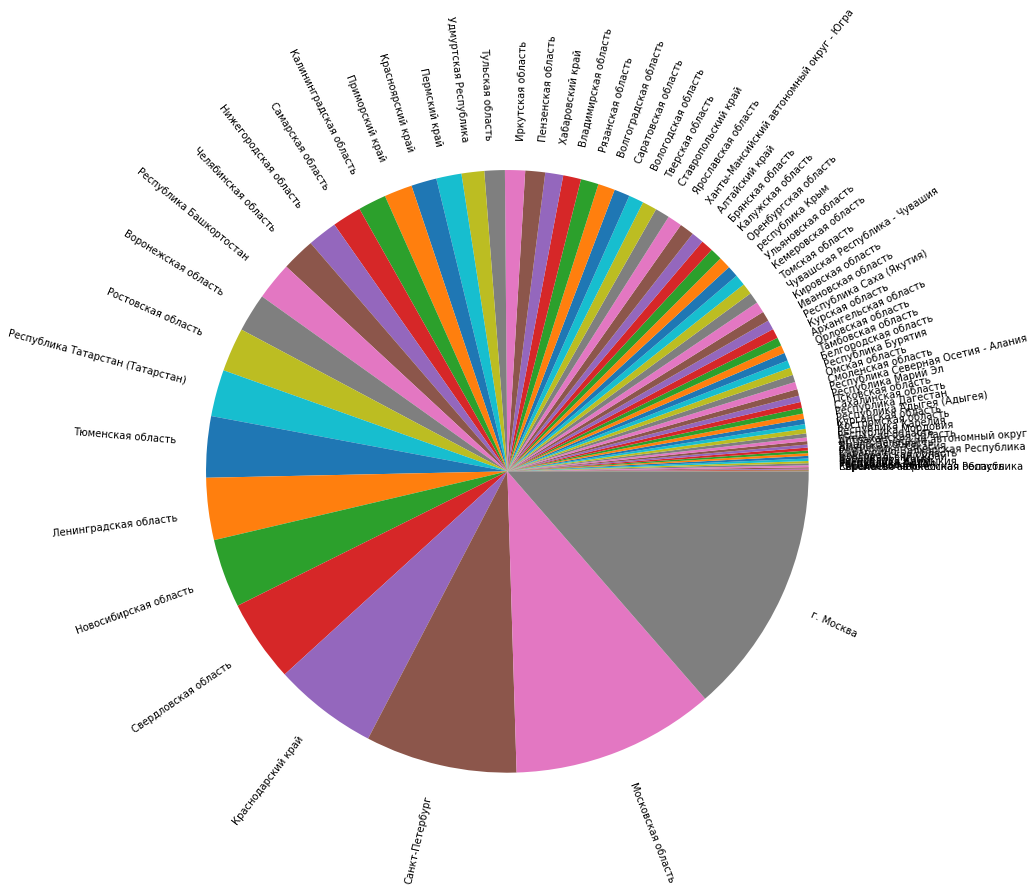

In [125]:
#Посмотрим на распределение объемов застройки по регионам за 2023 год
df_Anlz1_0=df_Anlz1[df_Anlz1.Year==2023]
df_Anlz1_0=df_Anlz1_0.sort_values(by='objSquareLiving',ascending=True)
plt.pie(df_Anlz1_0['objSquareLiving'], labels=df_Anlz1_0['region'].map(map_regions),rotatelabels=True, radius=1.5)

plt.show()

Выводы:

    -Лидируют по объему застройки Москва, Московская область и Санкт-Петербург
    - В некоторых регионых объемы застройки стремятся кнулю

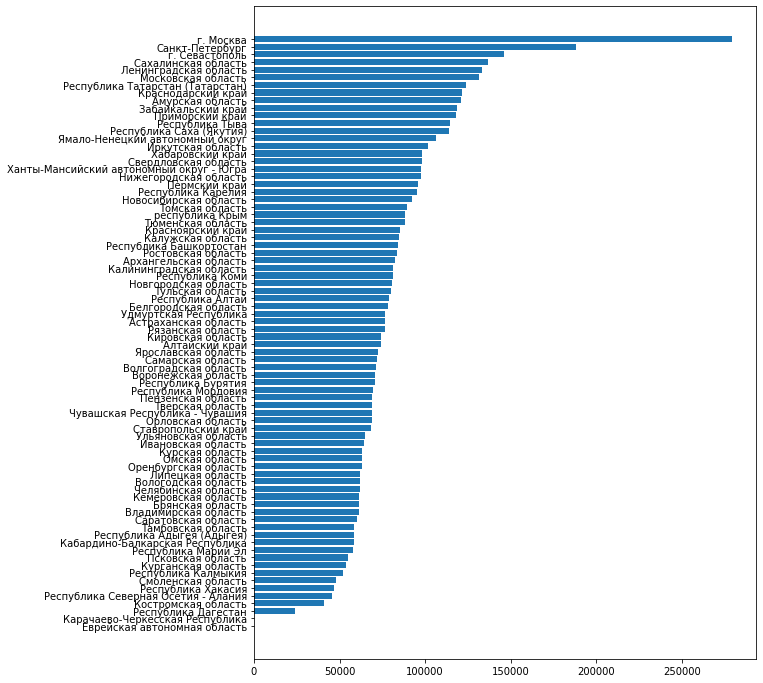

In [126]:
#Посмотрим на сотношение средних цен по регионам за 2023 год
df_Anlz1_0=df_Anlz1_0.sort_values(by='objPriceAvg',ascending=True)
plt.barh(df_Anlz1_0['region'].map(map_regions), df_Anlz1_0['objPriceAvg'])
plt.show()

Выводы: 
    -Лидируют по средней цене за м2 Москва, Московская область и Севастополь

In [129]:
#выберем для визуализации 5 максимальных и 5 минимальных региона по суммарной площади новостроек
df_tmp=df_Anlz1.groupby(by=['region']).agg({'objSquareLiving':'sum'})
v_rgns_max=df_tmp.loc[df_tmp['objSquareLiving'].nlargest(5).index].index
v_rgns_min=df_tmp.loc[df_tmp['objSquareLiving'].nsmallest(5).index].index
v_rgns=v_rgns_max.append(v_rgns_min)
df_Anlz1=df_Anlz1.reset_index()

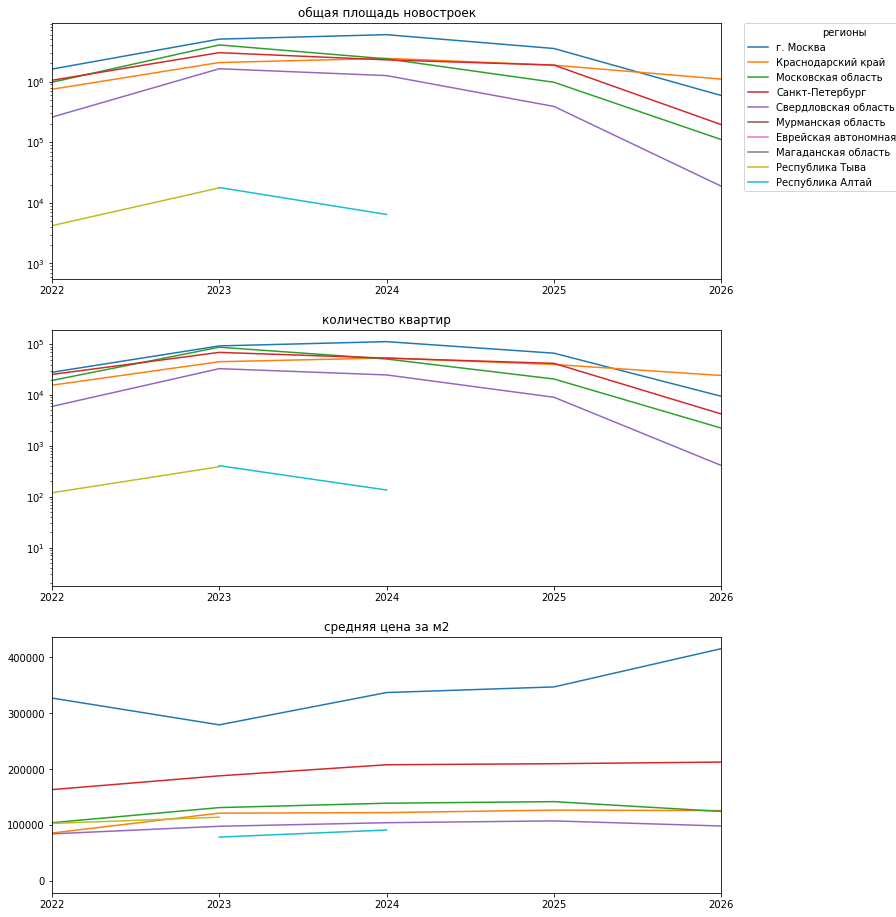

In [136]:
#визуализация

fig, axs = plt.subplots(nrows= 3 , ncols= 1 )
fig.set_size_inches(12,16)
for rg in v_rgns:
    axs[0].plot(df_Anlz1[df_Anlz1.region==rg]['Year'], df_Anlz1[df_Anlz1.region==rg]['objSquareLiving'])
    axs[1].plot(df_Anlz1[(df_Anlz1.region==rg)]['Year'], df_Anlz1[df_Anlz1.region==rg]['objFlatCnt'])
    axs[2].plot(df_Anlz1[(df_Anlz1.region==rg)]['Year'], df_Anlz1[df_Anlz1.region==rg]['objPriceAvg'])

fig.legend(title='регионы', labels=v_rgns.map(map_regions), bbox_to_anchor=(1.1, 0.78))

for i in range (0, 3):    
    
    #возьмем данный за ближайшие 5 лет
    axs[i].set_xlim([2022, 2026])
    
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(1))

axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].set_title('общая площадь новостроек')
axs[1].set_title('количество квартир')
axs[2].set_title('средняя цена за м2')

plt.show()

Выводы:
    - В наиболее активно строящихся регионах планы по застройке равномерные, без явных пиков или спадов в объемах выводимого жилья. Прослеживается уменьшение объемов к 2025-2026 году. Предположительно это объясняется тем, что - это довольно отдаленный срок, и планы на застройку еще не попали в базу.
    - В наименее активно строящихся регионах застройка происходит "штучно", четкие тенденции не прослеживаются 
    - Цены на жильё в Москве занчительно выше, чем в осталных регионах
    - Динамика цен в целом в сторону роста. В Москве есть спад на 2023 год, но дальше тоже рост

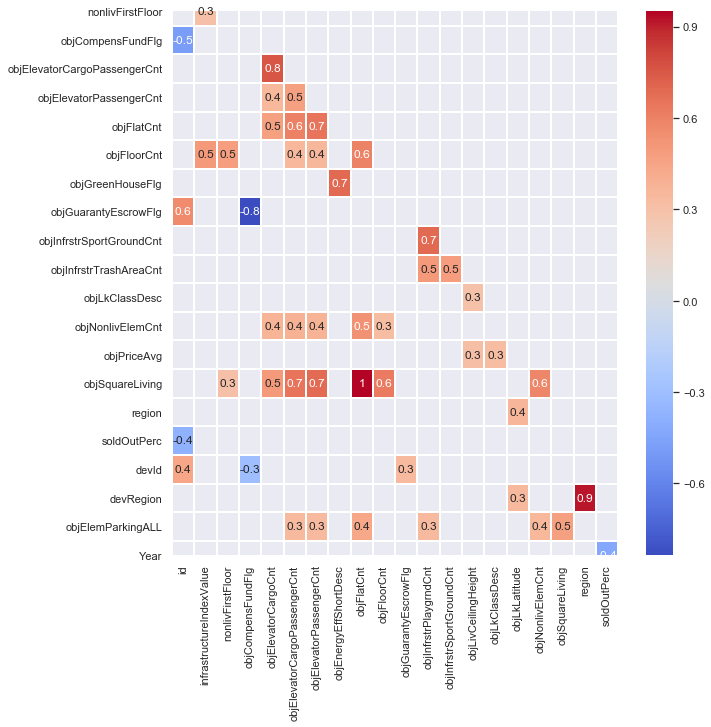

In [137]:
#отрисуем, как коррелиируются между собой параметры объектов по всем имеющимся данным
df_Anlz2=df_Objects.corr()

    #уберем строки и столбцы, в которых данные слабо коррелируются
    # для этого убираем главную диагональ и все, что правее (данные в правой части дублируют данные в левой)
mask=np.ones_like(df_Anlz2).astype(int)
mask[np.triu_indices_from(mask)]=0
df_Anlz2 = df_Anlz2 * (mask)
    #отметаем все, что слабо коррелируется  (оставим коэфф корреляции больше 0,3)
df_Anlz2=df_Anlz2[(abs(df_Anlz2)>0.3)].dropna(axis = 0, thresh=1).dropna(axis = 1, thresh=1)

    #отрисуем тепловую карту
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(
    df_Anlz2,
    cmap= 'coolwarm',
    linewidths=1,
    annot = True,
        #mask=mask,
    fmt='.1g'
    )

Выводы:
- Количество общая плошадь жилых помещений в доме находятся в прямой пропорции
- большинство застройщиков строят в своем регионе
- Продажа через эскроу счета и гарантии от фондов находятся в сильной обратной зависимости.
- Прямые связи средней силы имеются между количеством лифтов и количеством (и площадью) жилых помещений. 
  Связь количества лифтов с этажностью здания тоже есть, но более слабая.
- Прямой связью связаны количество спортивных и игровых площадок
- Наблюдаестя положительная связь средней силы между энергоэффективностью дома и признаком "зеленый дом". 
  А вот явной связи между энергоэффективностью и географической широтой не выявлено. Хотя такая связь казалась бы логичной.
- есть зависимость стоимости от класса жилья, но она слабая. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


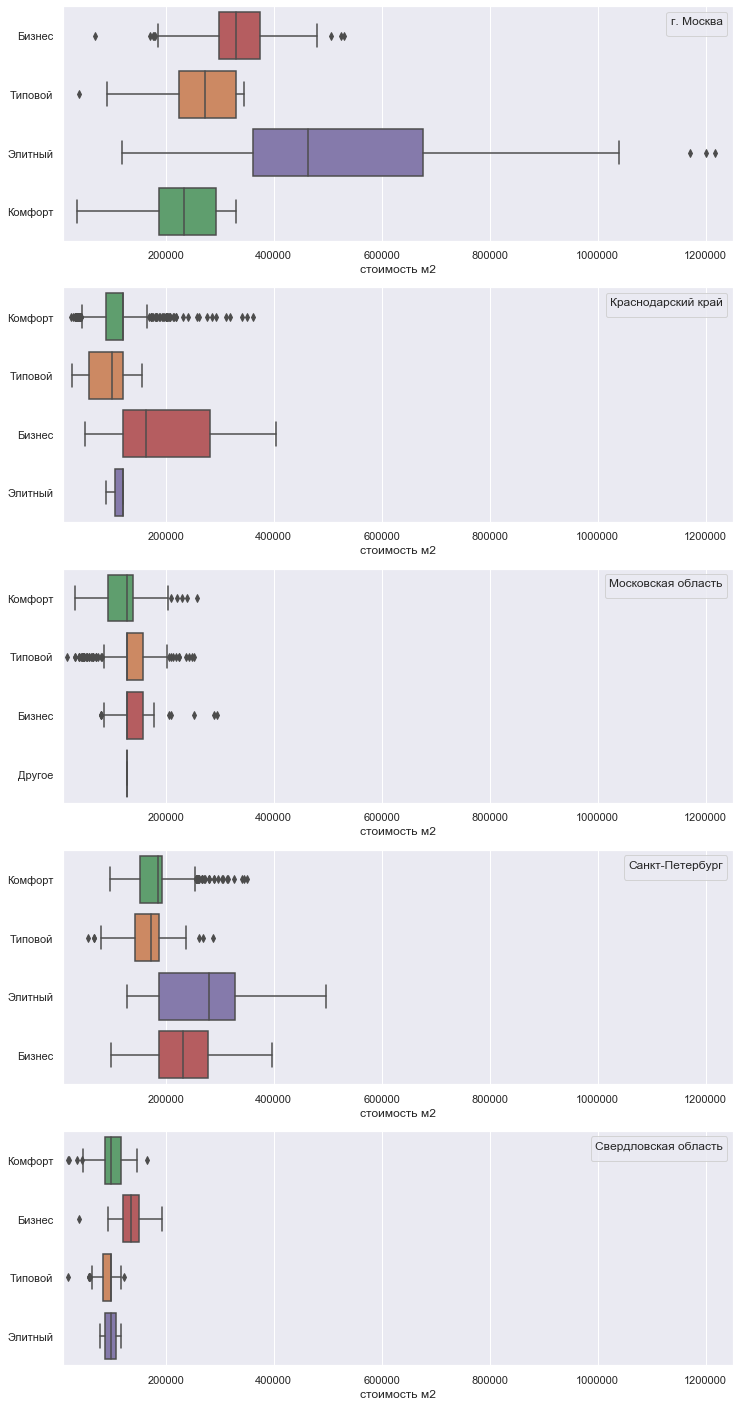

In [138]:
#визуализируем разброс средней стоимости м2 в регионах с максимально активной застройкой

df_Anlz3=df_Objects[df_Objects.region.isin(v_rgns_max)][['objPriceAvg','region','objLkClassDesc']]

#df_Anlz3['region_nm']=df_Anlz3['region'].map(map_regions)
map_LkClass_reverse = dict(zip(map_LkClass.values(), map_LkClass.keys()))
df_Anlz3['objLkClassDesc']=df_Anlz3['objLkClassDesc'].map(map_LkClass_reverse)
v_xmin=10** 4#df_Anlz3['objPriceAvg'].min()
v_xmax=1250000#df_Anlz3['objPriceAvg'].max()

v_palette=dict(zip(map_LkClass.keys(), sns.color_palette(n_colors=len(map_LkClass))))


fig, axs = plt.subplots(len(v_rgns_max), 1)
fig.set_size_inches(12,5*len(v_rgns_max))

for i, rgn in enumerate(v_rgns_max,  start=0):
    sns.boxplot(
        y='objLkClassDesc',
        x='objPriceAvg', 
        data=df_Anlz3[df_Anlz3.region==rgn],
        ax=axs[i] ,
        palette=v_palette
        )
    axs[i].legend(title=map_regions.get(rgn), loc='upper right')
    axs[i].set_xlabel('стоимость м2')
    axs[i].set_ylabel(None)
    axs[i].set_xlim([v_xmin, v_xmax])
    #axs[i].set_xscale('symlog')


Выводы:

- Во всех рассмотренных регионах диапазоны цен на жильё разных классов во многом перекрываются. То есть, разброс стоимости м2 жилья в большей степени зависит от региона и от каких-то других факторов внутри региона, чем от класса жилья. Это говорит о том, что класс жилья не является решающим фактором в ценообразовании
- Наибольший разброс по стоимости жилья наблюдается в Москве, остобенно в элитном классе. Б большом диапазоне варьируются цены на жильё бизнес-класса в Краснодарском крае, и на бизнес- и элит- классы в Санкт-Петербурге.
- Интересная картина по Свердловской области. 
  Диапазон цен на жильё комфорт класса здесь полностью перекрывает диапазоны типового и элитного классов. А медианы цен на эти три класса примерно совпадают.

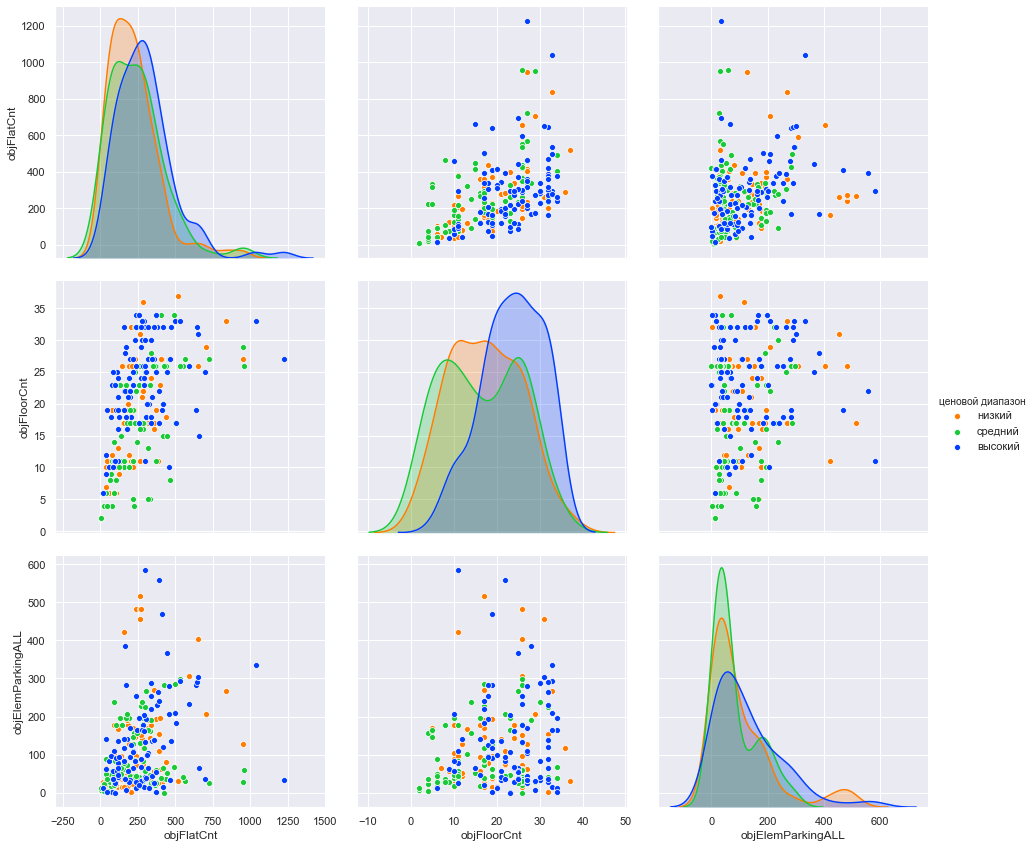

In [139]:
#рассмотрим данные по Свердловской области.
#Попробуем проследить зависимость между этажностью зданий, количеством квартир, количеством парковочных мест и ценой за м2.
df_Anlz4=df_Objects[df_Objects.region==66][['objPriceAvg','objFlatCnt','objFloorCnt','objElemParkingALL']]

#разделим данные на 3 ценовых категории
df_Anlz4['PriceGrp']=pd.qcut(df_Anlz4['objPriceAvg'], q=3, labels=['низкий', 'средний', 'высокий'])

v_palette=dict(zip(df_Anlz4['PriceGrp'].unique(), sns.color_palette('bright', n_colors=len(df_Anlz4['PriceGrp'].unique()))))

#отрисуем попарную зависимость параметров
df_Anlz4=df_Anlz4[['PriceGrp','objFlatCnt','objFloorCnt','objElemParkingALL']]
df_Anlz4
pg=sns.pairplot(df_Anlz4,
        hue='PriceGrp',
        height=4,
        aspect=1,
        palette=v_palette,
       )
pg._legend.remove()
pg.add_legend(title='ценовой диапазон')

Выводы:
    - Четких тенденций для отдельных ценовых групп не наблюдается.
    - в более домах выше 30 этажей находится жилье в более высоком ценовом диапазоне 
    - количество квартир в основном растет с увеличением количества этажей, для всех ценовых групп
    - с увеличением количества этажей и квартир увеличивается разброс по количеству парковочных мест. При этом для многих многоэтажных и многоквартинрных домов проектируется небольшое количество парковок.